<a href="https://colab.research.google.com/github/kaixinrongzi/SaintGeorgeClassify/blob/main/SaintGeorgeClassify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load dataset

In [14]:
# ! pip install gdown
# ! pip install Pillow
# ! pip install torch torchvision
# ! pip install matplotlib
# ! pip install opencv-python
# ! pip install scikit-learn
# ! pip install numpy

In [1]:
import os

WORKSPACE = '/content/drive/MyDrive/SaintGeorgeClassify'
# WORKSPACE = 'SaintGeorgeClassify'

os.makedirs(WORKSPACE, exist_ok=True)

In [2]:
import subprocess, os
import gdown
import shutil

# download data
# os.makedirs('/content/drive/MyDrive/SaintGeorgeClassify', exist_ok=True)
gdown.download_folder('https://drive.google.com/drive/folders/1lW-hGvRq557THjMbOu1Xw8wZ9ssMHXp7?usp=drive_link', output=WORKSPACE )


Retrieving folder contents


Processing file 1HRsuyIdmSS5YDv3QpF0zas7_Zjq1bH9B data.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1HRsuyIdmSS5YDv3QpF0zas7_Zjq1bH9B
From (redirected): https://drive.google.com/uc?id=1HRsuyIdmSS5YDv3QpF0zas7_Zjq1bH9B&confirm=t&uuid=53a79e95-61ba-49a6-b3a8-4655b63d14dd
To: /content/drive/MyDrive/SaintGeorgeClassify/data.zip
100%|██████████| 576M/576M [00:03<00:00, 184MB/s]
Download completed


['/content/drive/MyDrive/SaintGeorgeClassify/data.zip']

In [3]:
# unzip data

import zipfile
from pathlib import Path

outer_zip = Path(WORKSPACE + '/data.zip')
target_dir = Path(WORKSPACE + '/data')    # where inner zip contents should go
tmp_dir = Path(WORKSPACE + '/tmp/outer_extracted')  # temporary extraction of outer zip

tmp_dir.mkdir(parents=True, exist_ok=True)
target_dir.mkdir(parents=True, exist_ok=True)

# 1) Extract outer zip to temporary folder
with zipfile.ZipFile(outer_zip, 'r') as z:
    z.extractall(tmp_dir)

# 2) Find inner zip files and extract each into target_dir (or separate subfolders)
for inner in tmp_dir.rglob('*.zip'):
    # if you want each inner zip content in its own subfolder:
    out_sub = target_dir
    out_sub.mkdir(parents=True, exist_ok=True)
    try:
      with zipfile.ZipFile(inner, 'r') as iz:
          iz.extractall(out_sub)
    except Exception as e:
      print(e)

# clean up temp folder
import shutil; shutil.rmtree(tmp_dir)

File is not a zip file
File is not a zip file


Global Variables

In [2]:
import os

# WORKSPACE = '/content/drive/MyDrive/SaintGeorgeClassify/'
DATA_DIR = os.path.join(WORKSPACE, "data")
POSITIVE_DIR = os.path.join(DATA_DIR, 'georges')
POSITIVE_DIR = os.path.join(DATA_DIR, 'non_georges')
RESULTS_DIR = os.path.join(WORKSPACE, "results")
MISCLASSIFIED_DIR = os.path.join(RESULTS_DIR, "misclassified")
LOG_PATH = os.path.join(RESULTS_DIR, "training_logs.log")

In [3]:
 # make dirs
from pathlib import Path

directory = Path(RESULTS_DIR)
if not directory.exists():
   directory.mkdir(parents=True, exist_ok=True)

directory = Path(MISCLASSIFIED_DIR)
if not directory.exists():
   directory.mkdir(parents=True, exist_ok=True)



package Entity

In [4]:
import os
from typing import Tuple

from PIL import Image
from torch.utils.data import DataLoader, Dataset

# 1. Data loading and Preprocessing
class CustomDataset(Dataset):
    def __init__(self, image_dir:str, transform=None):
        self.image_dir = image_dir
        self.image_paths = []
        self.labels = []

        self.class_names = ['georges', 'non_georges']
        self.class_to_label = {'georges' : 1,
                               'non_georges' : 0}
        self.transform = transform

        for class_name in self.class_names:
            class_dir = os.path.join(image_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                self.image_paths.append(image_path)
                self.labels.append(self.class_to_label[class_name])

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx:int):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure consistent color format
        label = self.labels[idx]

        if self.transform:
           image = self.transform(image)

        return image, label, image_path


class SubsetDataset(Dataset):

    def __init__(self, dataset: CustomDataset, indices:list[int], transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx: int):
        image, label, image_path = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label, image_path


package Service

In [5]:
import copy
import threading
import matplotlib.pyplot as plt
import torch
import logging
import cv2
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


class Trainer:

    def __init__(self, criterion):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.counter = 0
        self.patience = 5
        self.best_val_loss = float('inf')

        criterion.weight = criterion.weight.to(self.device)
        self.criterion = criterion

        for h in logging.root.handlers[:]:
          logging.root.removeHandler(h)
        logging.basicConfig(filename=LOG_PATH,
                            level=logging.INFO,
                            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)
        self.logger.propagate = True

        self.best_models = {}



    # use different optimizers: Adam and AdamW
    def train_dispatch(self, model, training_dataset:Dataset, val_dataset:Dataset, test_dataset:Dataset, optimizer, num_epochs:int, patience:int):
        self.patience = patience

        threads = []
        thread = threading.Thread(target=self.train, args=(model, training_dataset, val_dataset, test_dataset, optimizer, num_epochs), name=f"AdamW, lr={learning_rate}, weight_decay={weight_decay}")
        threads.append(thread)
        thread.start()

        # Main thread waits for all of its child threads
        for thread in threads:
           thread.join()

        return self.best_models[model.__class__.__name__]


    def train(self, model, training_dataset:Dataset, val_dataset: Dataset, test_dataset:Dataset, optimizer, num_epochs:int):

        # Log start
        self.logger.info(f'Model Training Start: {model.__class__.__name__}', exc_info=True)

        train_loader = DataLoader(training_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        test_losses = []
        test_accuracies = []
        for epoch in range(num_epochs):

            running_loss = 0.0
            correct = 0
            total = 0
            model.train()

            for inputs, labels, _ in train_loader:
                inputs = inputs.to(self.device)  # 将inputs放到GPU上
                labels = labels.to(self.device)  # 将inputs放到GPU上

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = self.criterion(outputs, labels.squeeze().long())
                loss.backward()   # calculate gradients
                optimizer.step()  # update parameters based on gradients: parameter -= learning_rate * gradient
                running_loss += loss.item()
                _, predicted = torch.max(outputs.detach(), 1)
                correct += (predicted == labels).sum().item()
                total += len(inputs)

            average_train_loss = running_loss/len(train_loader)
            average_train_accuracy = correct / total

            train_losses.append(average_train_loss)
            train_accuracies.append(average_train_accuracy)

            print(f"{threading.current_thread().name}: Epoch {epoch + 1}, training loss: {average_train_loss}")
            print(f"{threading.current_thread().name}: Epoch {epoch + 1}, training accuracy: {average_train_accuracy}")

            # Evaluate the model using val dataset
            res = self.validate(model, val_loader, epoch, val_losses, val_accuracies)
            if res == 1:
               # early exit
               break

            # Test the model using test dataset
            self.test(model, test_loader, epoch, test_losses, test_accuracies)

        print("Finished Training")
        # Log end
        self.logger.info(f'Model Training End: {model.__class__.__name__}', exc_info=True)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))    # 1 row, 2 columns

        ax1.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
        ax1.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
        ax1.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss")
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f"{model.__class__.__name__}: Loss")
        ax1.legend()

        ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy")
        ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy")
        ax2.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Test Accuracy")
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title(f"{model.__class__.__name__}: Accuracy")
        ax2.legend()

        threading.Thread(target=lambda: plt.savefig(os.path.join(RESULTS_DIR, model.__class__.__name__ + 'metrics.png'))).start()
        threading.Thread(target=lambda: plt.plot()).start()


    def validate(self, model, val_loader: DataLoader, epoch: int, val_losses, val_accuracies):
        model.eval()    # set the model to evaluation mode (mute training)

        val_loss = 0.0
        total = correct = 0
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(self.device)  # 将inputs放到GPU上
                labels = labels.to(self.device)  # 将inputs放到GPU上
                outputs = model(inputs)
                loss = self.criterion(outputs, labels.squeeze().long())
                _, predicted = torch.max(outputs.detach(), 1)
                correct += (predicted == labels).sum().item()
                val_loss += loss.item()
                total += len(inputs)

        val_loss /= len(val_loader)
        average_val_accuracy = correct / total
        print(f'{threading.current_thread().name}: Epoch {epoch + 1}, Validation Loss: {val_loss}')
        print(f'{threading.current_thread().name}: Epoch {epoch + 1}, Validation accuracy: {average_val_accuracy}')
        val_losses.append(val_loss)
        val_accuracies.append(average_val_accuracy)

        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(RESULTS_DIR, f'{model.__class__.__name__}_best_model.pth'))    # save the best model
            self.best_models[model.__class__.__name__] = copy.deepcopy(model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping trigger")
                # model.load_state_dict(torch.load('best_model.pth'))   # load the best model
                return 1
        return 0


    def test(self, model, test_loader: DataLoader, epoch: int, test_losses, test_accuracies):
        model.eval()    # set the model to evaluation mode (mute training)

        val_loss = 0.0
        total = correct = 0
        all_predicted = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels, _ in test_loader:
                inputs = inputs.to(self.device)  # 将inputs放到GPU上
                labels = labels.to(self.device)  # 将inputs放到GPU上
                outputs = model(inputs)
                loss = self.criterion(outputs, labels.squeeze().long())
                _, predicted = torch.max(outputs.detach(), 1)
                correct += (predicted == labels).sum().item()
                val_loss += loss.item()
                total += len(inputs)
                # Collect batch predictions and labels
                all_predicted.extend(predicted.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())


        val_loss /= len(test_loader)
        average_val_accuracy = correct / total
        print(f'{threading.current_thread().name}: Epoch {epoch + 1}, Test Loss: {val_loss}')
        print(f'{threading.current_thread().name}: Epoch {epoch + 1}, Test accuracy: {average_val_accuracy}')
        test_losses.append(val_loss)
        test_accuracies.append(average_val_accuracy)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predicted)
        precision = precision_score(all_labels, all_predicted)
        recall = recall_score(all_labels, all_predicted)
        f1 = f1_score(all_labels, all_predicted)
        print(f'Test Accuracy: {accuracy:.4f}')
        print(f'Test Precision: {precision:.4f}')
        print(f'Test Recall: {recall:.4f}')
        print(f'Test F1: {f1:.4f}')








In [6]:
class Tester:

    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        for h in logging.root.handlers[:]:
          logging.root.removeHandler(h)
        logging.basicConfig(filename=os.path.join(RESULTS_DIR, 'test_results.log'),
                            level=logging.INFO,
                            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)
        self.logger.propagate = True


    def test(self, model, dataset: Dataset):
        model.eval()    # set the model to evaluation mode (mute training)

        val_loss = 0.0
        total = correct = 0
        all_predicted = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels, _ in test_loader:
                inputs = inputs.to(self.device)  # 将inputs放到GPU上
                labels = labels.to(self.device)  # 将inputs放到GPU上
                outputs = model(inputs)
                loss = self.criterion(outputs, labels.squeeze().long())
                _, predicted = torch.max(outputs.detach(), 1)
                correct += (predicted == labels).sum().item()
                val_loss += loss.item()
                total += len(inputs)
                # Collect batch predictions and labels
                all_predicted.extend(predicted.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())


        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predicted)
        precision = precision_score(all_labels, all_predicted)
        recall = recall_score(all_labels, all_predicted)
        f1 = f1_score(all_labels, all_predicted)
        print(f'Test Accuracy: {accuracy:.4f}')
        print(f'Test Precision: {precision:.4f}')
        print(f'Test Recall: {recall:.4f}')
        print(f'Test F1: {f1:.4f}')

        # Log those results as reference later on
        self.logger.info(f'Model Name: {model.__class__.__name__}', exc_info=True)
        self.logger.info(f'Test Accuracy: {accuracy:.4f}', exc_info=True)
        self.logger.info(f'Test Precision: {precision:.4f}', exc_info=True)
        self.logger.info(f'Test Recall: {recall:.4f}', exc_info=True)
        self.logger.info(f'Test F1: {f1:.4f}', exc_info=True)
        self.logger.info("------------------------------------------------", exc_info=True)


    def _save_miss_classification_input(self, inputs_paths, labels_np, predicted_np):

       for i in range(labels_np.shape[0]):
          if labels_np[i] == predicted_np[i]:
            continue
          image_path = inputs_paths[i]
          predicted_label = int(predicted_np[i])
          true_label = int(labels_np[i])
          image = Image.open(image_path)
          image_name = image_path.split(os.path.sep)[-1]
          image.save(os.path.join(MISCLASSIFIED_DIR, f"pred_{predicted_label}_true_{true_label}_{image_name}"))

package Controller

In [7]:
import os
from pathlib import Path
import math
import numpy as np
import torch.cuda
import torchvision
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision.models import EfficientNet_B0_Weights
from torchvision.models import ViT_B_16_Weights
from torchvision.transforms import transforms
import albumentations.augmentations.crops

# global variables
TEST_DATASET = None

class SaintGeorgeClassify:

    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer


    def run(self, dataset_dir, epoch_nums):

        # data transformers to augment dataset
        train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=224, scale=(0.5,1.0), ratio=(3/4,4/3)),  # Randomly crop and resize to the specified size
            transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
            transforms.RandomRotation(degrees=15),  # Randomly rotate the image by ±15 degrees
            # transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1,2.0)),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
            transforms.ToTensor(),  # Convert the image to a tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            # Normalization (standard example values if ImgNet, often used for pretrained models)
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
        ])

        # Note: Validation and test DO NOT need augmentations.
        valid_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # Split dataset into test, val, and test
        positive_images = os.listdir(os.path.join(dataset_dir, 'georges'))
        positive_labels = [1 for _ in range(len(positive_images))]
        negative_images = os.listdir(os.path.join(dataset_dir, 'non_georges'))
        negative_labels = [0 for _ in range(len(negative_images))]
        # all_images = positive_images + negative_images
        all_labels = np.array(positive_labels + negative_labels)

        all_indices = np.arange(len(all_labels))
        # First, split into train + val, and test
        train_indices, val_and_test_indices = train_test_split(all_indices,
                                                                    test_size=0.3,   # train+val/test = 70/30
                                                                    random_state=42,
                                                                    stratify=all_labels)
        # Second, split train + val into train and val
        train_labels = all_labels[train_indices]
        val_and_test_labels = all_labels[val_and_test_indices]
        val_indices, test_indices = train_test_split(val_and_test_indices,
                                                      test_size = 0.5,
                                                      random_state=42,
                                                      stratify=val_and_test_labels)

        # Create datasets using indices and transforms
        dataset = CustomDataset(image_dir = dataset_dir)
        train_dataset = SubsetDataset(dataset, train_indices, train_transforms)
        val_dataset = SubsetDataset(dataset, val_indices, valid_transform)
        test_dataset = SubsetDataset(dataset, val_and_test_indices, test_transform)
        global TEST_DATASET
        TEST_DATASET = test_dataset

        # get criterion
        weights = torch.tensor([len(negative_labels) / len(all_labels), len(positive_labels) / len(all_labels)])
        criterion = nn.CrossEntropyLoss(weight=weights)

        # Get appropriate model
        # train, val, and test model
        trainer = Trainer(criterion)
        best_model = trainer.train_dispatch(self.model, train_dataset,
                                            val_dataset, test_dataset,
                                            self.optimizer,
                                            epoch_nums,
                                            max(5, math.ceil(epoch_nums * 0.2)))

            # # test model
            # model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, f'{model.__class__.__name__}_best_model.pth')))
            # trainer.test(best_model, test_dataset)

        # model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        # model.fc = nn.Sequential(
        #     nn.Linear(model.fc.in_features, 1), # Binary classification: output size = 1
        #     nn.Sigmoid()    # Sigmoid activation
        # )
        # model.to(self.device)

        # # Get appropriate optimizer
        # optimizer = Adam(model.parameters(), lr=0.001)





run <- entry point of the program

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 1, training loss: 0.43005339819192884
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 1, training accuracy: 0.7842105263157895
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 1, Validation Loss: 0.262965394321967
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 1, Validation accuracy: 0.8947368421052632
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 1, Test Loss: 0.27572226896882057
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 1, Test accuracy: 0.887719298245614
Test Accuracy: 0.8877
Test Precision: 0.9031
Test Recall: 0.8164
Test F1: 0.8576
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 2, training loss: 0.33508749067783355
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 2, training accuracy: 0.8411027568922306
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 2, Validation Loss: 0.2379145570513275
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 2, Validation accuracy: 0.9052631578947369
AdamW, lr=0.0001, weight_decay=1e-06: Epoch 2, Test Loss: 0.25526932545145536
Ada

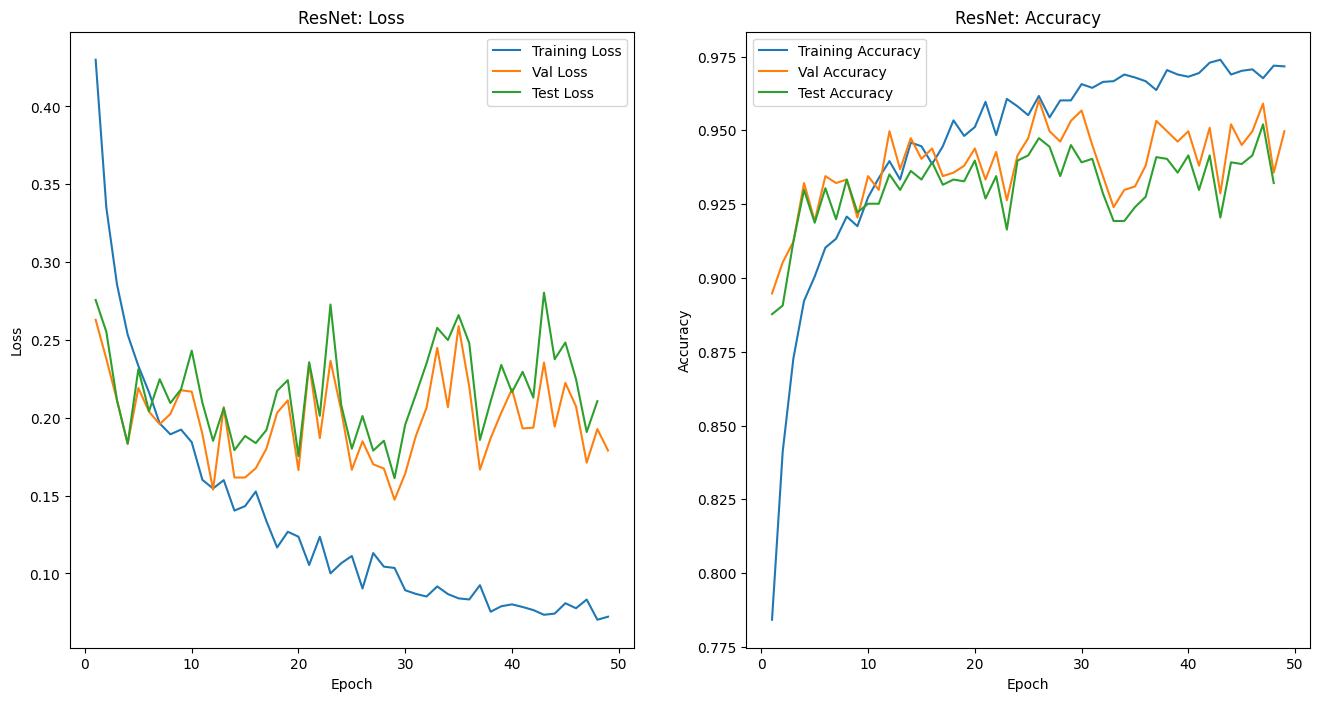

In [8]:
# Select models
import torchvision.models as models
from torchvision.models import ResNet34_Weights
from torchvision.models import EfficientNet_B0_Weights
from torchvision.models import ViT_B_16_Weights

# Select models
resnet34= models.resnet34(weights=ResNet34_Weights.DEFAULT)
resnet34.fc = nn.Sequential(
            nn.Linear(resnet34.fc.in_features, 2), # Binary classification: output size = 1
            nn.Sigmoid()    # Sigmoid activation
            )

resnext50 = models.resnext50_32x4d(pretrained=True)
resnext50.fc = nn.Linear(resnext50.fc.in_features, 2)

models = [resnet34, resnext50]

# Select hyperparameters
learning_rate = 0.0001
weight_decay = 1e-6
beta1 = 0.9
beta2 = 0.99

# set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train Models
for model in models:
   # select optimizer
   model_copy = copy.deepcopy(model)
   print(model_copy.__class__.__name__)
   model_copy.to(device)
   optimizer = optim.AdamW(model_copy.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(beta1, beta2), eps=1e-8, amsgrad=False)
   # train the model
   saint_george_classifier = SaintGeorgeClassify(model_copy, optimizer)
   saint_george_classifier.run(DATA_DIR, 100)



In [ ]:
# test models
# get models
resnet18 = models.resnet18()
resnet18.fc = nn.Sequential(
            nn.Linear(resnet18.fc.in_features, 2), # Binary classification: output size = 1
            nn.Sigmoid()    # Sigmoid activation
)
resnet18.load_state_dict(torch.load(os.path.join(RESULTS_DIR, f'{resnet18.__class__.__name__}_best_model.pth')))

efficientNet = models.efficientnet_b0()
efficientNet.classifier[1] = nn.Linear(efficientNet.classifier[1].in_features, 2)
efficientNet.load_state_dict(torch.load(os.path.join(RESULTS_DIR, f'{efficientNet.__class__.__name__}_best_model.pth')))

ViT_B_16 = models.vit_b_16()
ViT_B_16.heads.head = nn.Linear(in_features=768, out_features=2)
ViT_B_16.load_state_dict(torch.load(os.path.join(RESULTS_DIR, f'{ViT_B_16.__class__.__name__}_best_model.pth')))

models_to_test = [resnet18, efficientNet, ViT_B_16]

# test models
for model in models_to_test:
    tester = Tester()
    tester.test(model, TEST_DATASET)

In [1]:
import torch
torch.cuda.empty_cache()

In [15]:
for filename in os.listdir(MISCLASSIFIED_DIR):
  file_path = os.path.join(MISCLASSIFIED_DIR, filename)
  if os.path.isfile(file_path):
    os.remove(file_path)